In [1]:
!pip install -q transformers accelerate bitsandbytes peft torchinfo torchmetrics
!pip install -q pytorch-lightning wandb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.2/828.2 kB 29.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Dict
import math
from collections import defaultdict
import time

# PyTorch ecosystem imports
from torch.cuda.amp import GradScaler  # Mixed precision training
from torch import amp
from transformers import AutoTokenizer, GPT2Tokenizer  # HuggingFace tokenizers
import torch._dynamo as dynamo  # For torch.compile

# Set seeds
np.random.seed(42)
torch.manual_seed(42)

# Colab GPU detection and setup
if torch.cuda.is_available():
  device = torch.device('cuda')
  print(f"GPU: {torch.cuda.get_device_name(0)}")
  print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
  device = torch.device('cpu')
  print("No GPU available, using CPU")

GPU: Tesla T4
Memory: 14.7 GB


# Autoregressive Generation

In [3]:
class SimpleLanguageModel:
  """Vanilla Autoregressive text generation"""

  def __init__(self, vocab_size: int, context_length:int ):
    self.vocab_size = vocab_size
    self.context_length = context_length

    # Simple bigram probs as transition matrix. A “transition matrix” originates from Markov chain theory: A Markov chain is a stochastic process where the probability of the next state depends only on the current state (the Markov property). In a Markov chain with 𝑛 n states, the transition matrix encodes all the probabilities of moving from one state to another. Entry 𝑃 𝑖 𝑗 P ij ​ = probability of transitioning from state 𝑖 i to state 𝑗 j
    self.transition_matrix = np.random.dirichlet(np.ones(vocab_size), size=vocab_size) # [V, V] stochastic matrix
    print(f"Transition matrix shape: {self.transition_matrix.shape}")
    print(f"Sample row (sums to 1): {self.transition_matrix[0,:]}  sum={self.transition_matrix[0].sum():.3f}")

  def get_next_token_probs(self, context: List[int]) -> np.ndarray:
    """Get prob distrib for next token given the context"""

    if len(context) == 0:
      ## If no context apply Uniform distrib
      return(np.ones(self.vocab_size)/self.vocab_size)

    last_token = context[-1] # Bigram uses just the latest token to predict the next
    print(f"Last token: {last_token}, vocab_size: {self.vocab_size}")

    probs = self.transition_matrix[last_token] # prob P(next|last)
    print(f"\nContext: {context} -> Last token: {last_token}")
    print(f"Next token probs: {probs[:5]} ... (showing first 5)")
    return probs

  def generate(self, prompt: List[int], max_new_tokens: int, strategy: str = 'greedy') -> List[int]:
    """Generate tokens autoregressively"""

    context = prompt.copy()

    for i in range(max_new_tokens):
      # get prob distrib for nxt token
      probs = self.get_next_token_probs(context[-self.context_length:]) # slicing and using the last context_length tokens in the prompt(=context)


      if   strategy == 'greedy':
        next_token = np.argmax(probs) # Choose most likely, deterministic
        print(f"Step {i}: Greedy selected token {next_token} with p={probs[next_token]:.3f}")

      elif strategy == 'sample':
        next_token = np.random.choice(self.vocab_size, p=probs) # Sample from ditrib
        print(f"Step {i}: Sampled token {next_token} with p={probs[next_token]:.3f}")


      context.append(next_token) # Starts from the prompt/context and keeps generating increasing it

    return(context)

##Simple Test

In [4]:
# Test vanilla implementation
vocab_size = 10  # Small vocab for visualization
model = SimpleLanguageModel(vocab_size=vocab_size, context_length=5)

prompt = [1, 2, 3]
print(f"\nGenerating from prompt: {prompt}\n")

# Compare greedy vs sampling
greedy_output = model.generate(prompt, max_new_tokens=5, strategy='greedy')
print(f"\nGreedy output: {greedy_output}")

sampled_output = model.generate(prompt, max_new_tokens=5, strategy='sample')
print(f"\nSampled output: {sampled_output}")

Transition matrix shape: (10, 10)
Sample row (sums to 1): [0.04569443 0.29310702 0.12821656 0.0888967  0.01651702 0.01651424
 0.00582673 0.19584123 0.08949454 0.11989152]  sum=1.000

Generating from prompt: [1, 2, 3]

Last token: 3, vocab_size: 10

Context: [1, 2, 3] -> Last token: 3
Next token probs: [0.08215403 0.01642155 0.00590806 0.26119085 0.2960559 ] ... (showing first 5)
Step 0: Greedy selected token 4 with p=0.296

Greedy output: [1, 2, 3, np.int64(4)]
Last token: 3, vocab_size: 10

Context: [1, 2, 3] -> Last token: 3
Next token probs: [0.08215403 0.01642155 0.00590806 0.26119085 0.2960559 ] ... (showing first 5)
Step 0: Sampled token 0 with p=0.082

Sampled output: [1, 2, 3, 0]


# Autoregressive Generation with torch.compile and HuggingFace tokenizers

In [60]:
from torch.cuda.amp import GradScaler # mix precision
from torch import amp
from transformers import AutoTokenizer, GPT2Tokenizer

class OptimizedLanguageModel(nn.Module):

  def __init__(self, vocab_size:int, d_model:int, context_length:int):
    super(OptimizedLanguageModel, self).__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.context_length = context_length

    # Model components
    self.token_embedding = nn.Embedding(vocab_size, d_model)
    self.positional_embedding = nn.Embedding(context_length, d_model)
    self.attention = nn.MultiheadAttention(d_model, num_heads=4, batch_first=True)
    self.ln = nn.LayerNorm(d_model)
    self.lm_head = nn.Linear(d_model, vocab_size)

    print(f"Model params: {sum(p.numel() for p in self.parameters()):,}")

  def forward(self, idx:torch.Tensor) -> torch.Tensor:
    B, T = idx.shape

    tok_emb = self.token_embedding(idx) # [B,T,d_model]

    pos = torch.arange(T, device=idx.device)
    pos_emb = self.positional_embedding(pos)

    x = tok_emb + pos_emb

    # Causal mask
    mask = torch.triu(torch.ones(T,T,device=idx.device),diagonal=1).bool()
    x, _ = self.attention(x,x,x, attn_mask=mask) # scaled dot-product attention mechanism: [Q, K,V]

    # Layer Norm
    x = self.ln(x)

    # Unembedding
    logits = self.lm_head(x) # [B, T, vocab_size]

    return(logits)



## Using HF pretrained tokenizers
- Rust backend = Fast
- Manages special tokens, padding and truncation automatically.
- Good for edge cases, multilingual, fast.

In [61]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

print(f"\nTokenizer details:")
print(f"  Vocab size: {tokenizer.vocab_size}")
print(f"  Model max length: {tokenizer.model_max_length}")
print(f"  Special tokens: {tokenizer.special_tokens_map}")
print(f"  Example encoding: 'Hello world!' -> {tokenizer.encode('Hello world!')}")
print(f"  Decoded back: {tokenizer.decode(tokenizer.encode('Hello world!'))}")


# create and compile model
model = OptimizedLanguageModel(
    vocab_size=tokenizer.vocab_size,
    d_model=256,
    context_length=128
).to(device)


# torch.compile options:
# - default: balanced optim
# - reduce-overhead: best for small models, minimizes kernel launch overhead
# - max_autotune: best for large models, spends more time finding optimial kernels
# - max-autotune-no-cudagraphs: flexible, max optimization without cuda graphs

if hasattr(torch, 'compile') and device.type == 'cuda':
  # Compile only makes sense on GPU (uses Triton compiler for CUDA)
  model_compiled = torch.compile(model, mode="reduce-overhead")
  print("\n Model compiled with torch.compile (reduce-overhead mode)")
  print("  First call will be slow (compilation), subsequent calls fast")
else:
  model_compiled = model
  print("\ntorch.compile not available or on CPU, using eager mode")


# Autom Mixed Precision (amp)
# master weights in FLP32
# forward in FLP16
# Automatic casting based on operation
# loss scaling prevents grad underflow
# good for Tensor Cores, with too large models not fitting in mem and in Training

def generate_with_amp(
    model: nn.Module,
    prompt: str,
    tokenizer,
    max_new_tokens: int=50,
    temperature: float = 1.0) -> str:

  """Generate text with automatic mixed precision (AMP) """

  input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device) # pt for PyTorch, there is also for np and tf

  with torch.no_grad():
    # autocast
    with amp.autocast(device_type=device.type, enabled=(device.type=='cuda')):
      for i in range(max_new_tokens):
        # runs in float16 but some ops like softmax stay in float32
        logits = model_compiled(input_ids)
        logits = logits[:, -1, :] / temperature # Scaling with temp

        probs = F.softmax(logits, dim=-1) # softmax in float32  for stability
        next_token = torch.multinomial(probs, num_samples = 1)

        input_ids = torch.cat([input_ids, next_token], dim=1)

        if next_token.item() == tokenizer.eos_token_id:
          break

  return tokenizer.decode(input_ids[0], skip_special_tokens=True)



Tokenizer details:
  Vocab size: 50257
  Model max length: 1024
  Special tokens: {'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}
  Example encoding: 'Hello world!' -> [15496, 995, 0]
  Decoded back: Hello world!
Model params: 26,078,289

 Model compiled with torch.compile (reduce-overhead mode)
  First call will be slow (compilation), subsequent calls fast


## Comparing compiled vs eager mode

In [62]:
def benchmark_inference(model, compiled_model, input_ids, n_runs=10):

  # Warmup - triggers compilation
  print("Warming up (triggering compilation)...")
  for _ in range(2): # When benchmarking models, the first few runs are usually slower due to: Lazy initialization (loading kernels, allocating memory). JIT compilation overhead (torch.compile, TensorRT, XLA, etc). Running a couple of warmup iterations ensures those costs are paid upfront, so later timings reflect steady-state performance
    _ = model(input_ids)
    _ = compiled_model(input_ids)


  # Eager mode timing
  if device.type == 'cuda':
    torch.cuda.synchronize() # waiting for gpu to finish, cuda runs async

  start = time.time()
  for _ in range(n_runs): # Runs the model n_runs times on the same input_ids. Used to measure average runtime or variance across runs
    with torch.no_grad(): # not training
      _ = model(input_ids)

  if device.type == 'cuda':
    torch.cuda.synchronize() # waiting for gpu to finish, cuda runs async

  eager_time = time.time() -start


  # Compiled mode timing
  if device.type == 'cuda':
    torch.cuda.synchronize() # waiting for gpu to finish, cuda runs async

  start = time.time()
  for _ in range(n_runs): # Runs the model n_runs times on the same input_ids. Used to measure average runtime or variance across runs
    with torch.no_grad(): # not training
      _ = compiled_model(input_ids)

  if device.type == 'cuda':
    torch.cuda.synchronize()
  compiled_time = time.time() - start

  print(f"\nInference benchmark ({n_runs} runs):")
  print(f"  Eager mode: {eager_time:.3f}s ({1000*eager_time/n_runs:.1f}ms per call)")
  print(f"  Compiled: {compiled_time:.3f}s ({1000*compiled_time/n_runs:.1f}ms per call)")
  if compiled_time > 0:
    print(f"  Speedup: {eager_time/compiled_time:.2f}x")




### Test on realistic input

In [63]:
test_input = torch.randint(0, tokenizer.vocab_size, (1, 32)).to(device)
benchmark_inference(model, model_compiled, test_input)

# generate
prompt = "The future of AI is"
generated = generate_with_amp(model_compiled, prompt, tokenizer, max_new_tokens=20)
print(f"\nGenerated: {generated}")

print("\nNote: Have to do the benchmark with longer sequences or multiple prompts to see real gains.")

Warming up (triggering compilation)...

Inference benchmark (10 runs):
  Eager mode: 0.011s (1.1ms per call)
  Compiled: 1.391s (139.1ms per call)
  Speedup: 0.01x


/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7095: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(



Generated: The future of AI isurated Kash accomplishArsenalzin Bean Powers Turner DorStatic WILLPalestinian mereFebruaryvernuild manners inequariansiamond

Note: Have to do the benchmark with longer sequences or multiple prompts to see real gains.


# Sampling Methods

In [9]:
def apply_temperature(logits:np.ndarray, temperature:float) -> np.ndarray:
  """
  Applying temperature for scaling logits: y= softmax (u/τ)
  τ (tau) is the temperature: the closer to 0 more deterministic (more peak/lower entropy in the distrib) while higher than one flattens (higher entropy) all the distribution
  The name comes from thermodynamics were hotter systems are more likely to explore new states and colder are the opposite
  """

  if temperature == 0: # argmax, deterministic
    probs = np.zeros_like(logits)
    probs[np.argmax(logits)] = 1.0
    return(probs)

  # Scaling by temp
  scaled_logits = logits/temperature # u/τ
  print(f"Temperature {temperature}: logits range [{logits.min():.2f}, {logits.max():.2f}] -> [{scaled_logits.min():.2f}, {scaled_logits.max():.2f}]")

  # Apply softmax: exp(ui/τ) / Σ exp(uj/τ)
  exp_logits = np.exp(scaled_logits - np.max(scaled_logits)) # a diff scaling but for numerical stability  before softmax, preventing overflow of large values without chaning the softmax probs, benefits numerical predcision also
  probs = exp_logits / np.sum(exp_logits) # normalize to sum up to 1
  return(probs)

def top_k_sampling(logits: np.ndarray, k:int) -> np.ndarray:
  """
  Take the k top most probable, cut-off the rest and normalize only for those k tokens and then sample with the new probs
  Cons: k is a constant so inside those inside those k there could be very unlikely words, that's where top-p works better
  """

  probs = np.exp(logits - np.max(logits)) # numerical stability and prevent overflow. # np.max(array) → returns the largest value; np.argmax(array) → returns the index of the largest value.
  probs = probs / np.sum(probs) # softmax

  # top-k indices
  top_k_indices = np.argpartition(probs, -k)[-k:] # Indices of top k values. argpartition perform an indirect partition along the given axis using the algorithm specified by the kind keyword. It returns an array of indices of the same shape as a that index data along the given axis in partitioned order
  print(f"Top-{k} indices: {sorted(top_k_indices)}")

  # Create truncated distrib
  truncated_probs = np.zeros_like(probs)
  truncated_probs[top_k_indices] = probs[top_k_indices] # there rest are 0 but those specific indices
  truncated_probs = truncated_probs / np.sum(truncated_probs) # renormalizing

  print(f"Original entropy: {-np.sum(probs * np.log(probs + 1e-10)):.3f}")
  print(f"Top-{k} entropy: {-np.sum(truncated_probs * np.log(truncated_probs + 1e-10)):.3f}")
  return truncated_probs

def top_p_sampling(logits: np.ndarray, p:float) -> np.ndarray:
  """
  Nucleus sampling: keep smallest set with the cumulative prob >= p
  Does nt depend on a constant k like top-k
  """

  probs = np.exp(logits - np.max(logits))  # np.max(array) → returns the largest value; np.argmax(array) → returns the index of the largest value.
  probs = probs / np.sum(probs)

  # Sort probs desc
  sorted_indices = np.argsort(probs)[::-1] # get indices that would sort the array in a descending order
  sorted_probs = probs[sorted_indices]

  # find cutoff
  cumsum = np.cumsum(sorted_probs) # Cumulative sum. returns a new array holding the result is returned unless out is specified
  cutoff_idx = np.searchsorted(cumsum, p) + 1  # +1 ensures that the token where the cumulative probability first exceeds p is included. Searchsorted finds indices where elements should be inserted to maintain order
  print(f"Top-p={p}: keeping {cutoff_idx} tokens (out of {len(probs)})")

  # Keep only tokens in the nucleus
  nucleus_indices = sorted_indices[:cutoff_idx]
  truncated_probs = np.zeros_like(probs)
  truncated_probs[nucleus_indices] = probs[nucleus_indices] # the rest are zero
  truncated_probs = truncated_probs / np.sum(truncated_probs) # normalize over the sum of top-p probs, which is not just p because the last can exceed the p threshold (+1 above)

  print(f"Nucleus covers {np.sum(probs[nucleus_indices]):.3f} of probability mass")

  return(truncated_probs)


## Demonstrate all sampling methods


Original logits statistics:
Shape: (50,), Mean: -0.292, Std: 1.724

Temperature 0.5: logits range [-5.31, 2.81] -> [-10.62, 5.62]
Temperature 1.0: logits range [-5.31, 2.81] -> [-5.31, 2.81]
Temperature 2.0: logits range [-5.31, 2.81] -> [-2.66, 1.40]
Top-5 indices: [np.int64(1), np.int64(11), np.int64(14), np.int64(20), np.int64(31)]
Original entropy: 3.046
Top-5 entropy: 1.576
Top-10 indices: [np.int64(1), np.int64(2), np.int64(7), np.int64(11), np.int64(14), np.int64(17), np.int64(20), np.int64(31), np.int64(46), np.int64(49)]
Original entropy: 3.046
Top-10 entropy: 2.168
Top-20 indices: [np.int64(1), np.int64(2), np.int64(7), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(17), np.int64(20), np.int64(23), np.int64(26), np.int64(28), np.int64(31), np.int64(36), np.int64(40), np.int64(44), np.int64(46), np.int64(49)]
Original entropy: 3.046
Top-20 entropy: 2.664
Top-p=0.6: keeping 7 tokens (out of 50)
Nucleus covers 0.622 of probability ma

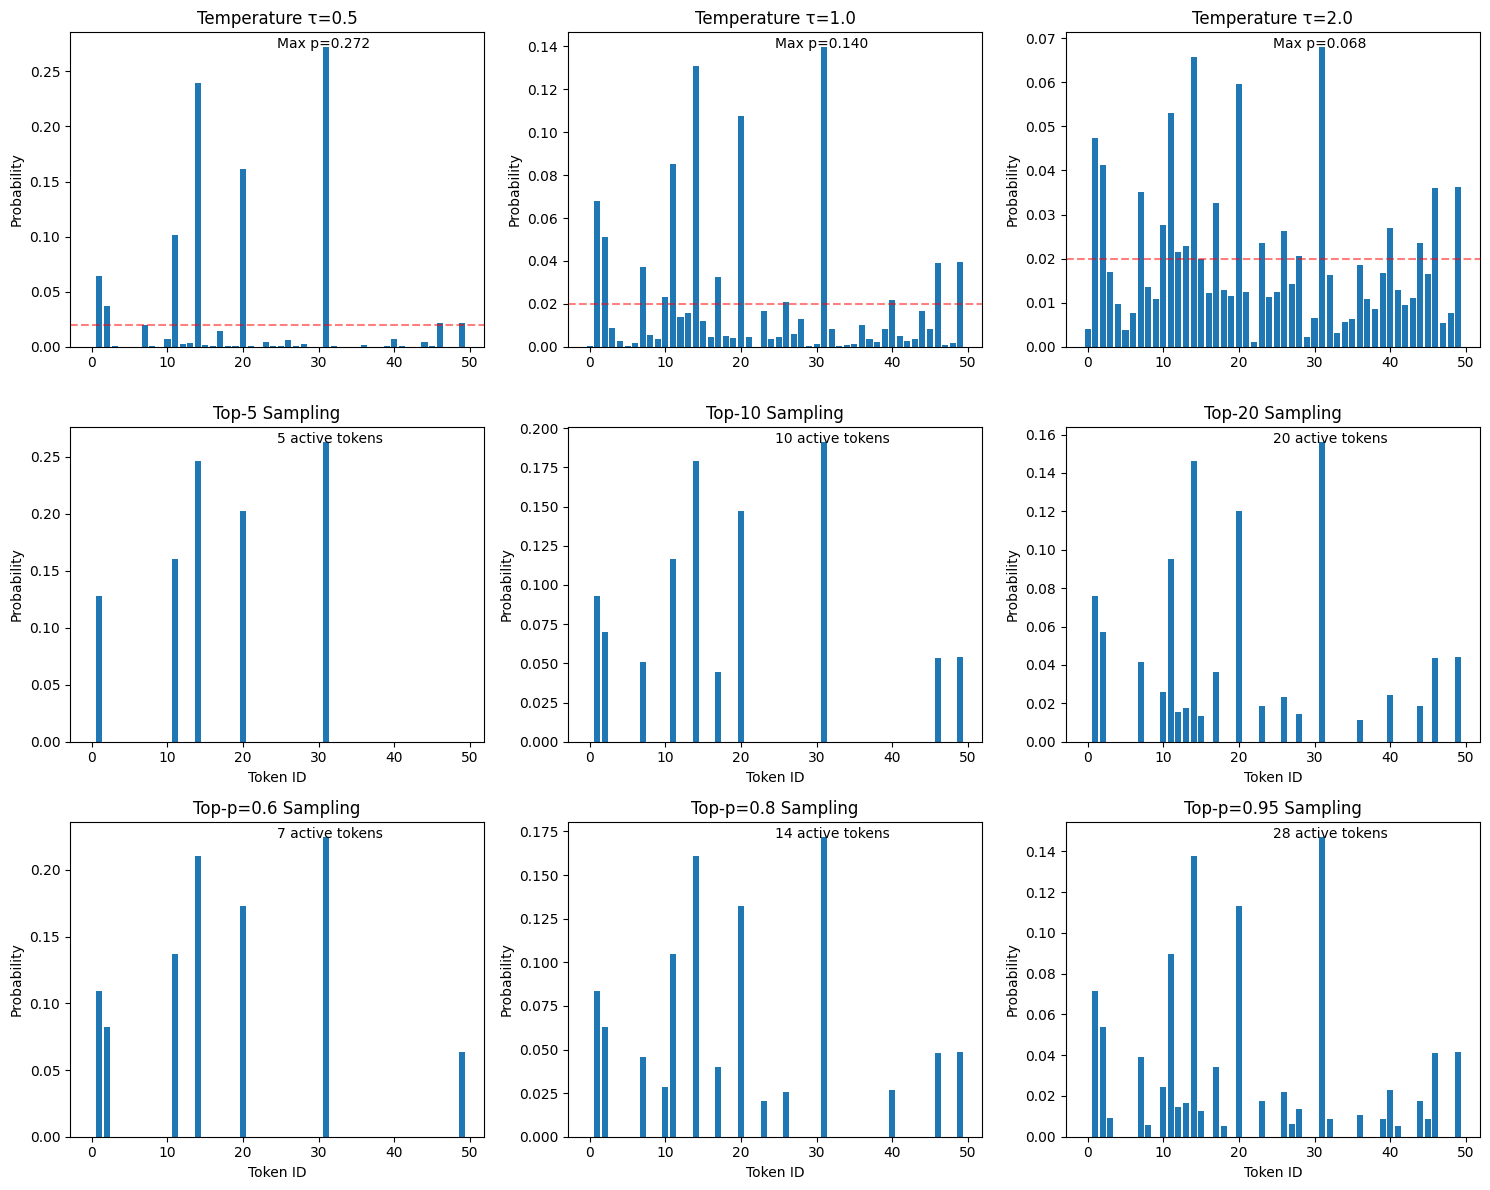

In [10]:
vocab_size = 50
logits = np.random.randn(vocab_size) * 2  # Random logits

print("Original logits statistics:")
print(f"Shape: {logits.shape}, Mean: {logits.mean():.3f}, Std: {logits.std():.3f}\n")

# Visualize different sampling strategies
fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # 3 rows now: temp, top-k, top-p

# Temperature sampling
for i, temp in enumerate([0.5, 1.0, 2.0]):
    probs = apply_temperature(logits, temp)
    axes[0, i].bar(range(vocab_size), probs)
    axes[0, i].set_title(f'Temperature τ={temp}')
    axes[0, i].set_ylabel('Probability')
    axes[0, i].axhline(y=1/vocab_size, color='r', linestyle='--', alpha=0.5, label='uniform')
    axes[0, i].text(0.5, 0.95, f'Max p={np.max(probs):.3f}', transform=axes[0, i].transAxes)

# Top-k sampling
for i, k in enumerate([5, 10, 20]):
    probs = top_k_sampling(logits, k)
    axes[1, i].bar(range(vocab_size), probs)
    axes[1, i].set_title(f'Top-{k} Sampling')
    axes[1, i].set_ylabel('Probability')
    axes[1, i].set_xlabel('Token ID')
    axes[1, i].text(0.5, 0.95, f'{np.sum(probs>0)} active tokens', transform=axes[1, i].transAxes)

# Top-p (nucleus) sampling
for i, p in enumerate([0.6, 0.8, 0.95]):
    probs = top_p_sampling(logits, p)
    axes[2, i].bar(range(vocab_size), probs)
    axes[2, i].set_title(f'Top-p={p} Sampling')
    axes[2, i].set_ylabel('Probability')
    axes[2, i].set_xlabel('Token ID')
    axes[2, i].text(0.5, 0.95, f'{np.sum(probs>0)} active tokens', transform=axes[2, i].transAxes)

plt.tight_layout()
plt.show()


# Training with Self-Supervision & Teacher Forcing

In [11]:
class AutoregressiveLM(nn.Module):
  """Basic autoregressive lang model for training"""

  def __init__(self, vocab_size: int, d_model:int, context_length:int):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.context_length = context_length

    # Embeddings [vocab_size, d_model]
    self.token_embedding = nn.Embedding(vocab_size, d_model)
    self.position_embedding = nn.Embedding(context_length, d_model)

    # Simple transformer block
    self.attention = nn.MultiheadAttention(
        d_model,
        num_heads=4,
        batch_first=True) # Changes the order of input output arguments expected.  batch_first: If True, then the input and output tensors are provided as (batch, seq, feature). Default: False (seq, batch, feature).

    # Standard practice for the feedforward hidden size d_ffn ≈ 4 × d_model
    self.ffn = nn.Sequential(
        nn.Linear(d_model, d_model * 4), # args: in_features: int, out_features: int,
        nn.ReLU(),
        nn.Linear(d_model * 4, d_model)
    )

    self.ln1 = nn.LayerNorm(d_model)
    self.ln2 = nn.LayerNorm(d_model)

    # Lang model head  (unembedding matrix)
    self.lm_head = nn.Linear(d_model,vocab_size, bias=False)
    print(f"Model initialized: vocab={vocab_size}, d_model={d_model}, context={context_length}")
    print(f"Parameters: {sum(p.numel() for p in self.parameters()):,}")


  def forward(self,
              idx: torch.Tensor,
              targets: Optional[torch.Tensor]=None):
    """
    Forward pass with Teacher Forcing
    idx: [batch, seq_len] token indices
    targets: [batch,seq_len] next token targets for training
    """

    B, T = idx.shape # batch size and sequence length

    # Token + position embedding
    tok_emb = self.token_embedding(idx) # [B, T, d_model] used Batch = True when defining
    pos = torch.arange(T, device = idx.device) # position indices [0,1..., T-1]
    pos_emb = self.position_embedding(pos) # [T, d_model]
    x = tok_emb + pos_emb # [B, T, d_model] Broadcasting position embeddings

    print(f"Embeddings: tok_emb {tok_emb.shape} + pos_emb {pos_emb.shape} = {x.shape}")


    # Mask for attn
    mask = torch.triu(torch.ones(T,T), diagonal=1).bool() # Upper triangular

    # Self-Attention block
    attn_out, _ = self.attention(x, x, x , attn_mask = mask) # applies attn to Q, K, V, with upper mask

    x = x + attn_out # Resid conneciotn
    x = self.ln1(x) # postnorm

    # Feedforward block
    ffn_out = self.ffn(x) # [B, T, d_model]
    x = x + ffn_out # Residual conn
    x = self.ln2(x) # post norm, prenorm would be bfr the resid connection

    logits = self.lm_head(x) # Unembedding matrix [B,T, vocab_size]
    print(f"Logits: {logits.shape}, range: [{logits.min():.2f}, {logits.max():.2f}]")

    loss = None
    if targets is not None:
      # Compute CE Loss for the Lang Modeling
      logits_flat = logits.view(-1, self.vocab_size) # [B,T, vocab_size] -> [B*T, vocab_size]  flatten the batch and sequence dimensions into a single dimension while keeping the vocabulary dimension intact. -1 is a placeholder that tells PyTorch to automatically infer that dimension so that the total number of elements stays the same
      targets_flat = targets.contiguous().view(-1)  # [B,T] ->[B*T] - flatten to 1D . view(-1) requires the tensor to be contiguous in memory, other options is reshape(-1) which does not require that

      # Cross-entropy: -Σ y_true * log(y_pred)
      loss = F.cross_entropy(logits_flat, targets_flat)
      print(f"Loss computation: logits {logits_flat.shape} vs targets {targets_flat.shape} = {loss:.4f}")

    return logits, loss

def train_step(model: nn.Module, data: torch.Tensor, optimizer: torch.optim.Optimizer):
  """Single training step with teacher forcing"""

  # Prepare input and targets
  inputs = data[:, :-1] # All but last token
  targets = data[:, 1:] # All but first token

  print(f"\nTeacher forcing setup:")
  print(f"Input sequence:  {inputs[0].tolist()}")
  print(f"Target sequence: {targets[0].tolist()}")
  print(f"Teaching model: predict token[i+1] from tokens[0:i+1]")

  # Forward pass
  logits, loss = model(inputs, targets)

  # Backward pass
  optimizer.zero_grad() # resetting before computing grads to not accum prev
  loss.backward()

  # Gradient stats
  total_norm = 0
  for p in model.parameters():
    if p.grad is not None:
      param_norm = p.grad.norm(2).item() # L2 / Ridge Norm of the gradient
      total_norm += param_norm ** 2

  total_norm = total_norm ** 0.5
  print(f"Gradient norm: {total_norm:.4f}")

  optimizer.step()
  return loss.item()


### Simple Test


In [12]:
# Small model and training
vocab_size = 100
d_model = 64
context_length =16
batch_size = 4
seq_len = context_length

model = AutoregressiveLM(vocab_size, d_model, context_length)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# Generate random data
data = torch.randint(0, vocab_size, (batch_size, seq_len + 1))  # +1 for targets
print("Generated Random Data:")
print(data)
print(f"\nTraining data shape: {data.shape}")
# Training loop
losses = []
for step in range(5):
  loss = train_step(model, data, optimizer)
  losses.append(loss)
  print(f"\nStep {step}: Loss = {loss:.4f}")

print(f"\nLoss trajectory: {losses}")


Model initialized: vocab=100, d_model=64, context=16
Parameters: 63,808
Generated Random Data:
tensor([[36, 58,  7, 99, 90, 12, 74, 89, 17, 54, 79, 50, 56, 54, 89, 36, 49],
        [ 8,  3, 53, 55, 62,  8, 93, 36, 41, 37, 11,  9, 53, 78, 42,  8, 62],
        [68, 12, 11, 76, 98, 58, 54, 55, 73, 47,  9, 17, 24, 51,  1, 19, 30],
        [ 6, 54, 10, 47, 23, 18, 22, 81, 95, 66, 62, 46, 12, 87, 62, 24, 59]])

Training data shape: torch.Size([4, 17])

Teacher forcing setup:
Input sequence:  [36, 58, 7, 99, 90, 12, 74, 89, 17, 54, 79, 50, 56, 54, 89, 36]
Target sequence: [58, 7, 99, 90, 12, 74, 89, 17, 54, 79, 50, 56, 54, 89, 36, 49]
Teaching model: predict token[i+1] from tokens[0:i+1]
Embeddings: tok_emb torch.Size([4, 16, 64]) + pos_emb torch.Size([16, 64]) = torch.Size([4, 16, 64])
Logits: torch.Size([4, 16, 100]), range: [-2.48, 2.13]
Loss computation: logits torch.Size([64, 100]) vs targets torch.Size([64]) = 4.8205
Gradient norm: 1.2066

Step 0: Loss = 4.8205

Teacher forcing setup:
I

#Fine-tuning: LoRA

In [45]:
class LoRALinear(nn.Module):
  """Linear layer with LoRA"""

  def __init__(self, in_features:int, out_features:int, rank: int=4, alpha:float=1.0):
    super().__init__()

    self.in_features = in_features
    self.out_features = out_features
    self.rank = rank
    self.alpha = alpha

    # Frozen pretrained weights
    self.weight = nn.Parameter(torch.randn(out_features, in_features)*0.02)
    self.weight.requires_grad = False # Freeze pretrained weights

    # LoRA parameters (trainable)
    self.lora_A = nn.Parameter(torch.randn(rank, in_features) * 0.02) # [r,in]
    self.lora_B = nn.Parameter(torch.zeros(out_features, rank)) # [out, r]  init to zero

    # Scaling factor
    self.scaling = alpha / rank

    print(f"LoRA Linear layer: [{in_features}] -> [{out_features}]")
    print(f"  Pretrained W: {self.weight.shape} = {self.weight.numel():,} params (frozen)")
    print(f"  LoRA A: {self.lora_A.shape} = {self.lora_A.numel():,} params")
    print(f"  LoRA B: {self.lora_B.shape} = {self.lora_B.numel():,} params")
    print(f"  Total trainable: {self.lora_A.numel() + self.lora_B.numel():,}")
    print(f"  Compression: {self.weight.numel() / (self.lora_A.numel() + self.lora_B.numel()):.1f}x")


  def forward(self, x:torch.Tensor) -> torch.Tensor:
    """Forward pass: h = x(W + BA * scaling)"""

    # Original computation: x @ W^T
    out_frozen = F.linear(x, self.weight)


    # LoRA computation:     x @ A^T @ B^T * scaling
    out_lora = x @ self.lora_A.T @ self.lora_B.T * self.scaling
    # x @ lora_A.T → [batch, seq, in] @ [in, rank] = [batch, seq, rank]
    # (x @ lora_A.T) @ lora_B.T → [batch, seq, rank] @ [rank, out] = [batch, seq, out]

    print(f"\nLoRA forward pass:")
    print(f"  Input: x {x.shape}")
    print(f"  Frozen path: x {x.shape} @ weight.T {self.weight.T.shape} = out_frozen {out_frozen.shape}")
    print(f"  LoRA path: x {x.shape} @ lora_A.T {self.lora_A.T.shape} @ self.lora_B.T {self.lora_B.T.shape} = out_lora {out_lora.shape}")
    print(f"  LoRA contribution norm: out_lora.norm {out_lora.norm():.4f}")

    return out_frozen + out_lora  # During inference, the output becomes h = xW + xAB (instead of the forward pass h = xW)



## Compare standard vs LoRA fine-tuning


In [46]:
def count_parameters(model: nn.Module) -> Tuple[int, int]:
  """Count total and trainable parameters"""
  total = sum(p.numel() for p in model.parameters())
  trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return total, trainable

# Standard linear layer
standard_linear = nn.Linear(512, 512)
total_std, trainable_std = count_parameters(standard_linear)
print(f"Standard Linear: {total_std:,} total, {trainable_std:,} trainable\n")

# LoRA linear layer
lora_linear = LoRALinear(512, 512, rank=8)
total_lora, trainable_lora = count_parameters(lora_linear)
print(f"\nLoRA Linear: {total_lora:,} total, {trainable_lora:,} trainable")
print(f"Parameter reduction: {(1 - trainable_lora/trainable_std)*100:.1f}%\n")

# Test forward pass
x = torch.randn(4, 16, 512)  # [batch, seq_len, features]
out_standard = standard_linear(x)
out_lora = lora_linear(x)

print(f"\nOutput shapes match: {out_standard.shape} == {out_lora.shape}\n")

Standard Linear: 262,656 total, 262,656 trainable

LoRA Linear layer: [512] -> [512]
  Pretrained W: torch.Size([512, 512]) = 262,144 params (frozen)
  LoRA A: torch.Size([8, 512]) = 4,096 params
  LoRA B: torch.Size([512, 8]) = 4,096 params
  Total trainable: 8,192
  Compression: 32.0x

LoRA Linear: 270,336 total, 8,192 trainable
Parameter reduction: 96.9%


LoRA forward pass:
  Input: x torch.Size([4, 16, 512])
  Frozen path: x torch.Size([4, 16, 512]) @ weight.T torch.Size([512, 512]) = out_frozen torch.Size([4, 16, 512])
  LoRA path: x torch.Size([4, 16, 512]) @ lora_A.T torch.Size([512, 8]) @ self.lora_B.T torch.Size([8, 512]) = out_lora torch.Size([4, 16, 512])
  LoRA contribution norm: out_lora.norm 0.0000

Output shapes match: torch.Size([4, 16, 512]) == torch.Size([4, 16, 512])



#Transformer with LoRA

In [47]:
class LoRATransformer(nn.Module):
  """Transformar with LoRA on attention layers"""

  def __init__(self, d_model: int, n_heads: int, lora_rank:int=4):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads
    self.d_head = d_model // n_heads

    # Replace standard projections with LoRA versions
    self.q_proj = LoRALinear(d_model, d_model, rank=lora_rank)
    self.k_proj = LoRALinear(d_model, d_model, rank=lora_rank)
    self.v_proj = LoRALinear(d_model, d_model, rank=lora_rank)
    self.o_proj = LoRALinear(d_model, d_model, rank=lora_rank)

    total, trainable = count_parameters(self)
    print(f"\nLoRA Transformer initialized:")
    print(f"  Total parameters: {total:,}")
    print(f"  Trainable parameters: {trainable:,} ({trainable/total*100:.1f}%)")


  def forward(self, x:torch.Tensor) -> torch.Tensor:
    B,L,D = x.shape
    print("\ninput x shape: ", x.shape, "\n")

    # Project to Q,K,V with LoRA
    Q = self.q_proj(x).view(B,L,self.n_heads, self.d_head).transpose(1,2)
    K = self.k_proj(x).view(B,L,self.n_heads, self.d_head).transpose(1,2)
    V = self.v_proj(x).view(B,L,self.n_heads, self.d_head).transpose(1,2)


    # Standard attention computation
    scores = torch.matmul(Q,K.transpose(-2,-1)) / math.sqrt(self.d_head)
    attn = F.softmax(scores,dim=-1)
    out = torch.matmul(attn,V)


    # Reshape and output projection
    out = out.transpose(1,2).contiguous().view(B,L,D) # Reshaped to input shape back. Using contiguous for memory layout
    out = self.o_proj(out)

    return out

## Testing LoRA transformer


In [48]:
lora_transformer = LoRATransformer(d_model=256, n_heads=8, lora_rank=4)
x = torch.randn(2, 32, 256)
output = lora_transformer(x)
print(f"\nLoRA Transformer output: {output.shape}")

LoRA Linear layer: [256] -> [256]
  Pretrained W: torch.Size([256, 256]) = 65,536 params (frozen)
  LoRA A: torch.Size([4, 256]) = 1,024 params
  LoRA B: torch.Size([256, 4]) = 1,024 params
  Total trainable: 2,048
  Compression: 32.0x
LoRA Linear layer: [256] -> [256]
  Pretrained W: torch.Size([256, 256]) = 65,536 params (frozen)
  LoRA A: torch.Size([4, 256]) = 1,024 params
  LoRA B: torch.Size([256, 4]) = 1,024 params
  Total trainable: 2,048
  Compression: 32.0x
LoRA Linear layer: [256] -> [256]
  Pretrained W: torch.Size([256, 256]) = 65,536 params (frozen)
  LoRA A: torch.Size([4, 256]) = 1,024 params
  LoRA B: torch.Size([256, 4]) = 1,024 params
  Total trainable: 2,048
  Compression: 32.0x
LoRA Linear layer: [256] -> [256]
  Pretrained W: torch.Size([256, 256]) = 65,536 params (frozen)
  LoRA A: torch.Size([4, 256]) = 1,024 params
  LoRA B: torch.Size([256, 4]) = 1,024 params
  Total trainable: 2,048
  Compression: 32.0x

LoRA Transformer initialized:
  Total parameters: 270,3

#Fine-tuning: PEFT with HuggingFace & bitsandbytes

In [49]:
from peft import LoraConfig, get_peft_model, TaskType # Hugging Face Parameter Efficient Fine-Tuning utilities
import bitsandbytes as bnb # 8-bit iptimization lib

class LoRA8bit(nn.Module):
  """
  Low Rank Adaptation:  W + BA where d (dim emb) approaches r (rank)
    Allows for 175B models on a single GPU
    100-1000x fewer params

  bitsandbytes: 8bit quantization for memory efficiency
  """

  def __init__(self, in_features: int, out_features:int, r:int =8,
               alpha:float = 32, use_8bit:bool = False):
    super().__init__()

    self.r = r
    self.alpha = alpha
    self.scaling = alpha / r

    # Frozen base weight
    self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.02)
    self.weight.requires_grad = False  # Freeze pretrained weights

    # LoRA matrices
    self.lora_A = nn.Parameter(torch.randn(r, in_features) * 0.02)
    self.lora_B = nn.Parameter(torch.zeros(out_features, r))

    self.use_8bit = use_8bit and torch.cuda.is_available()

    print(f"LoRA: {in_features}->{out_features} (rank={r})")
    print(f"  Compression: {self.weight.numel() / (self.lora_A.numel() + self.lora_B.numel()):.1f}x")

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    base_out = F.linear(x, self.weight) # Standar computation

    # LoRA computation:     x @ A^T @ B^T * scaling
    lora_out = (x @ self.lora_A.T @ self.lora_B.T) * self.scaling  # Lora computation
    # x @ lora_A.T → [batch, seq, in] @ [in, rank] = [batch, seq, rank]
    # (x @ lora_A.T) @ lora_B.T → [batch, seq, rank] @ [rank, out] = [batch, seq, out]

    return base_out + lora_out # During inference, the output becomes h = xW + xAB (instead of the forward pass h = xW)


In [50]:
def create_peft_config(r:int = 8, alpha:int=32, target_modules:List[str] = None ) -> LoraConfig:
  """PEFT Config for Hugging Face models"""

  if target_modules is None:
    target_modules = ["q_proj", "v_proj", "k_proj", "o_proj"]

  config = LoraConfig(
      r = r, # lora rank
      lora_alpha = alpha, # lora scaling
      target_modules = target_modules, # on which layers apply lora
      lora_dropout= 0.1, # dropuout for the lora layers
      bias = "none", # not training biases
      task_type=TaskType.CAUSAL_LM ## Define the adaptor task as Language Modelling
  )
  print(f"PEFT Config: r={r}, alpha={alpha}, scaling={alpha/r}")

  return config

## Compare efficiency


In [51]:
class FullModel(nn.Module):
  def __init__(self, vocab_size:int, d_model:int):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, d_model)
    self.transformer = nn.TransformerEncoderLayer(d_model, nhead=8, batch_first=True )
    self.lm_head = nn.Linear(d_model, vocab_size)


In [52]:
class LoRAModel(nn.Module):
  def __init__(self, vocab_size:int, d_model:int, r:int = 8):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.embedding.weight.requires_grad = False

    self.q_proj = LoRA8bit(d_model, d_model, r=r)  # LoRA for Q projection
    self.k_proj = LoRA8bit(d_model, d_model, r=r)  # LoRA for K projection
    self.v_proj = LoRA8bit(d_model, d_model, r=r)  # LoRA for V projection
    self.o_proj = LoRA8bit(d_model, d_model, r=r)  # LoRA for output projection

    self.lm_head = nn.Linear(d_model, vocab_size)
    self.lm_head.weight.requires_grad = False


In [56]:
d_model = 768
vocab_size = 50257

full_model = FullModel(vocab_size, d_model)
lora_model = LoRAModel(vocab_size, d_model, r=8)

def count_parameters(model):
  total = sum(p.numel() for p in model.parameters())
  trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return total, trainable

full_total, full_trainable = count_parameters(full_model)
lora_total, lora_trainable = count_parameters(lora_model)

print("\nParameter Efficiency:")
print(f"Full: {full_trainable:,} trainable")
print(f"LoRA: {lora_trainable:,} trainable")
print(f"Reduction: {(1 - lora_trainable/full_trainable)*100:.1f}%")

LoRA: 768->768 (rank=8)
  Compression: 48.0x
LoRA: 768->768 (rank=8)
  Compression: 48.0x
LoRA: 768->768 (rank=8)
  Compression: 48.0x
LoRA: 768->768 (rank=8)
  Compression: 48.0x

Parameter Efficiency:
Full: 82,758,993 trainable
LoRA: 99,409 trainable
Reduction: 99.9%


In [57]:
def train_with_8bit_adam(model: nn.Module, train_loader, num_steps: int = 10):
  """8-bit Adam: 75% less optimizer memory"""

  lora_params = [p for n, p in model.named_parameters() if 'lora' in n and p.requires_grad]

  if torch.cuda.is_available() and hasattr(bnb.optim, 'Adam8bit'):
    optimizer = bnb.optim.Adam8bit(lora_params, lr=3e-4)  # 8-bit Adam optimizer
    print("Using 8-bit Adam")
  else:
    optimizer = torch.optim.AdamW(lora_params, lr=3e-4)
    print("Using standard AdamW")

  model.train()

  for step, batch in enumerate(train_loader):
    if step >= num_steps:
      break

    # FIX: Unpack the batch from the list
    batch = batch[0]  # Extract tensor from list
    batch = batch.to(device)
    embeddings = model.embedding(batch)

    q = model.q_proj(embeddings)  # Apply LoRA to Q
    k = model.k_proj(embeddings)  # Apply LoRA to K
    v = model.v_proj(embeddings)  # Apply LoRA to V

    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_model)
    attn = F.softmax(scores, dim=-1)
    out = torch.matmul(attn, v)
    out = model.o_proj(out)  # Apply LoRA to output

    loss = out.mean()

    optimizer.zero_grad()
    loss.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(lora_params, max_norm=1.0)
    optimizer.step()

    if step % 2 == 0:
      print(f"Step {step}: Loss={loss.item():.4f}")

## Training

In [58]:
lora_model = lora_model.to(device)

dummy_loader = torch.utils.data.DataLoader(
  torch.utils.data.TensorDataset(torch.randint(0, vocab_size, (100, 32))),
  batch_size=4
)

train_with_8bit_adam(lora_model, dummy_loader, num_steps=10)

Using 8-bit Adam
Step 0: Loss=-0.0002
Step 2: Loss=-0.0007
Step 4: Loss=0.0004
Step 6: Loss=-0.0001
Step 8: Loss=0.0007


## Memory analysis


In [59]:
print("\nMemory Footprint:")

def get_model_memory(model):
  param_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
  grad_bytes = sum(p.numel() * p.element_size() for p in model.parameters() if p.requires_grad)
  optimizer_bytes = grad_bytes * 2  # Adam momentum + variance
  return param_bytes, grad_bytes, optimizer_bytes

full_p, full_g, full_o = get_model_memory(full_model)
lora_p, lora_g, lora_o = get_model_memory(lora_model)

print(f"Full: {(full_g + full_o)/1024**2:.2f} MB (grad+opt)")
print(f"LoRA: {(lora_g + lora_o)/1024**2:.2f} MB (grad+opt)")
print(f"Memory saved: {(1 - (lora_g + lora_o)/(full_g + full_o))*100:.1f}%")


Memory Footprint:
Full: 947.10 MB (grad+opt)
LoRA: 1.14 MB (grad+opt)
Memory saved: 99.9%
